Nama : Raafi Dimas
Dicoding

In [ ]:
#Import library
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datacolab/london_merged.csv', parse_dates=['timestamp'], index_col='timestamp')
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [ ]:
data.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [ ]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['month'] = data.index.month

In [ ]:
data

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,19,1,3,1
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,20,1,3,1
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,21,1,3,1


# EDA

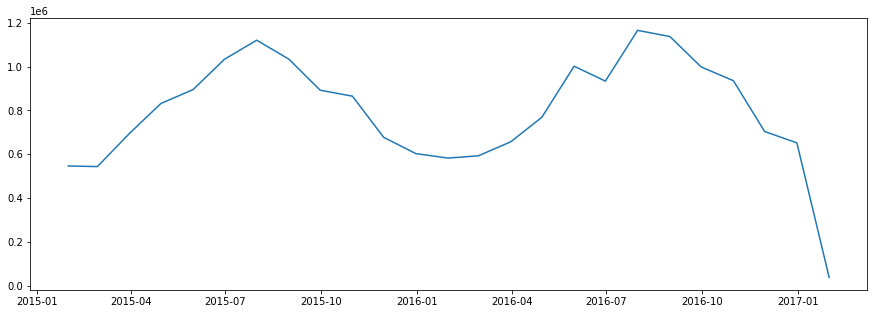

In [ ]:
import matplotlib.pyplot

data_by_month = data.resample('M').sum()

time = data_by_month.index.values
test = data_by_month['cnt'].values

plt.figure(figsize=(15,5))
plt.plot(time, test)

penjualan diawal tahun 2015 naik pada tahun 2016 tetapi turun pada tahun 2017.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

train_size = int(len(data) * 0.8) # bobot 80%
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

print(train.shape, test.shape)

(13931, 13) (3483, 13)


In [ ]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
cnt_transformer = transformer.fit(train[['cnt']])

train['cnt'] = cnt_transformer.transform(train[['cnt']])

test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [ ]:
scale_col = ['t1', 't2', 'hum', 'wind_speed']
scale_transformer = transformer.fit(train[scale_col].to_numpy())

train.loc[:, scale_col] = scale_transformer.transform(
    train[scale_col].to_numpy())

test.loc[:, scale_col] = scale_transformer.transform(
    test[scale_col].to_numpy())

In [ ]:
from tqdm import tqdm_notebook as tqdm

#Split the data into x_train and y_train data sets
x_train = []
y_train = []
time_steps = 24
for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
#Create the x_test and y_test data sets
x_test = []
y_test = data.loc[:,'cnt'].iloc[train_size:len(data)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

Train size:
(13907, 24, 12) (13907,)
Test size:
(3459, 24, 12) (3483,)


In [ ]:
class my_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 0.1):
            print("MAE has reached below 10%")

    def on_train_end(self, epoch, logs={}):
        print('Done')

callbacks = my_Callback()

In [95]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 
model = Sequential()
model.add(Bidirectional(LSTM(50,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [97]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.000e-04)
model.compile(loss = tf.keras.losses.Huber(),
                optimizer = optimizer,
                 metrics = ["mae"])

In [100]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               25200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 25,301
Trainable params: 25,301
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(x_train, y_train, epochs=150, batch_size=24, validation_split=0.2, callbacks = callbacks, shuffle=True)

Epoch 1/150
464/464 [==============================] - 10s 21ms/step - loss: 0.0206 - mae: 0.1360 - val_loss: 0.0257 - val_mae: 0.1476
Epoch 2/150
464/464 [==============================] - 9s 20ms/step - loss: 0.0209 - mae: 0.1361 - val_loss: 0.0253 - val_mae: 0.1455
Epoch 3/150
464/464 [==============================] - 9s 20ms/step - loss: 0.0204 - mae: 0.1338 - val_loss: 0.0247 - val_mae: 0.1433
Epoch 4/150
464/464 [==============================] - 9s 20ms/step - loss: 0.0204 - mae: 0.1346 - val_loss: 0.0285 - val_mae: 0.1560
Epoch 5/150
464/464 [==============================] - 9s 20ms/step - loss: 0.0198 - mae: 0.1328 - val_loss: 0.0254 - val_mae: 0.1453
Epoch 6/150
464/464 [==============================] - 9s 19ms/step - loss: 0.0200 - mae: 0.1326 - val_loss: 0.0252 - val_mae: 0.1447
Epoch 7/150
464/464 [==============================] - 9s 19ms/step - loss: 0.0192 - mae: 0.1296 - val_loss: 0.0246 - val_mae: 0.1421
Epoch 8/150
464/464 [==============================] - 9s 20m

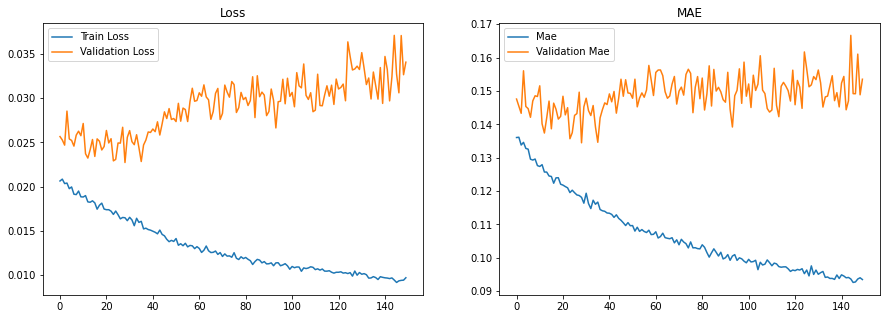

In [102]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
    ax[1].set_title('MAE')
    ax[1].plot(history.epoch, history.history["mae"], label="Mae")
    ax[1].plot(history.epoch, history.history["val_mae"], label="Validation Mae")
    ax[0].legend()
    ax[1].legend()

show_final_history(history)